In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.auto import tqdm
from typing import Optional, Tuple

In [4]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

In [6]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [9]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])
pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])

In [10]:
pv = pv.set_index('datetime')

In [11]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,21,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,21,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

# data loader

In [71]:
# Data 1

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, data_comp, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]
            # print(X.shape)

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            # print(Y.shape)

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, 1=power)

        if data_comp==1:
            Y = Y[:,:,0][:,:,None]
            print(Y.shape)

        if data_comp==2:
            X = Y[:,:,1:].copy()
            Y = Y[:,:,0][:,:,None]
            print(X.shape)
            print(Y.shape)
        
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

In [83]:
iw = 24
ow = 24
num_feature = 8

# params_ ={'iw': 24,
#           'ow': 24,
#           'num_feature':8,
#           'data_comp':1,
#           'stride':24}

train_dataset = windowDataset(pv_train[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=24)
test_dataset = windowDataset(pv_test[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=24)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

(354, 24, 1)
(10, 24, 1)


In [84]:
a = next(iter(train_loader))

In [85]:
a[0].shape

torch.Size([64, 24, 8])

In [86]:
a[1].shape

torch.Size([64, 24, 1])

In [88]:
len(train_loader)

6

In [89]:
len(test_loader)

1

# model

In [90]:
# weight init 0.01 -> 0.1로 증가

# 뒷부분 padding 제외하는 함수
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding) # 뒷 padding 부분 제거?
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)] 

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [91]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.1)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1.transpose(1, 2))

In [100]:
def train(model, train_loader, optimizer, criterion, device='cuda'):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.permute(0,2,1).to(device).float().contiguous()
        y = y.permute(0,2,1).to(device).float().contiguous()

        # print(x.shape)

        out = model(x).permute(0,2,1)
        # print(out[:,:,0].unsqueeze(2).shape)
        # print(y.shape)
        # loss = criterion(out[:,:,0], y[:,:,0])
        loss = criterion(y, out[:,:,0].unsqueeze(2))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        total_loss += loss.cpu().item()
    train_loss = total_loss/len(train_loader)

    return out.detach().cpu().numpy(), y.detach().cpu().numpy(), train_loss

def predict(model, test_loader, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []

    for t, (x, y) in enumerate(test_loader):
        x = x.permute(0,2,1).to(device).float()
        y = y.permute(0,2,1).to(device).float()

        with torch.no_grad():
            out = model(x).permute(0,2,1)
        outputs.append(list(out.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))
        # loss = criterion(y[:,:,0], out[:,:,0])
        loss = criterion(y, out)
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)
    # print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), test_loss

# data component 1

In [101]:
device='cuda'
model = TCN(input_size=8, output_size=1, num_channels=[10]*4, kernel_size=5, dropout=0.0).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [133]:
pbar = tqdm(range(8000))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, optimizer, criterion, device='cuda')
    *result_test, test_loss = predict(model, test_loader, criterion, device='cuda')

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/8000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([34, 1, 1])) that is different to the input size (torch.Size([34, 1, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [126]:
pred = result_test[0]
true = result_test[1]

In [127]:
pred = power_scaler.inverse_transform(pred[:,0,:].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,0,:].reshape(-1,1))

In [128]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)].copy()

In [129]:
len(pred)

240

In [130]:
len(true)

240

In [131]:
pv_test.shape

(240, 19)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


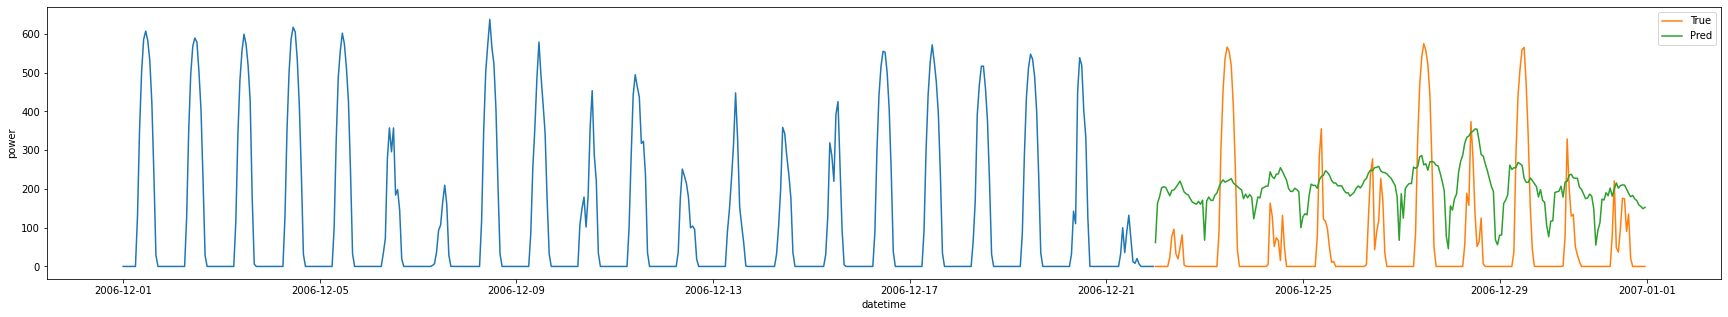

In [132]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()